In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,109532,111592,111592,111592,115751,117158,118659,120216,120216,120216,120216,125937,127464,129021,130113,131586,131586,131586,134653,134653,136643,137853,137853,137853,137853,141489,142414,142414,143183,143439,143439,143439,144285,145008,145552,145996,146523,146523,146523,147985
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132499,132506,132509,132512,132513,132514,132521,132523,132526,132534,132535,132537,132544,132557,132565,132580,132587,132592,132597,132608,132616,132629,132647,132665,132686,132697,132740,132763,132797,132828,132853,132875,132891,132922,132952,132999,133036,133081,133121,133146
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,137403,137772,138113,138465,138840,139229,139626,140075,140550,141007,141471,141966,142447,143032,143652,144483,145296,146064,146942,147883,148797,149906,151103,152210,153309,154486,155784,157005,158213,159563,160868,162155,163660,165204,167131,168668,170189,171392,172564,173922
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13877,13882,13882,13882,13882,13900,13911,13918,13918,13918,13918,13918,13991,14021,14050,14075,14075,14075,14155,14167,14167,14239,14273,14273,14273,14359,14379,14379,14464,14498,14498,14498,14577,14586,14586,14655,14678,14678,14678,14747
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38091,38371,38528,38556,38613,38682,38849,38965,39089,39172,39230,39300,39375,39491,39593,39791,39881,39958,40055,40138,40327,40530,40631,40707,40805,40906,41061,41227,41405,41629,41736,41780,41879,42110,42288,42486,42646,42777,42815,42970


In [ ]:
df_confirmed.shape

(279, 563)

In [ ]:
country="Tunisia"

In [ ]:
df_confirmed_country= df_confirmed[df_confirmed["Country/Region"]==country]
df_confirmed_country.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21
252,NaN,Tunisia,33.886917,9.537499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,395362,398829,403493,407017,408931,414182,420103,426879,432761,438945,443631,447161,455091,464914,473229,481735,491021,497613,501923,510396,518609,526487,533274,540798,546233,548753,554911,555997,558306,558306,563930,569289,573394,575002,578962,582638,586146,589565,595532,596775


In [ ]:
df_confirmed_country.shape

(1, 563)

In [ ]:
df_confirmed_country=pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])

In [ ]:
df_confirmed_country.shape

(559, 1)

In [ ]:
df_confirmed_country.head()

,confirmed
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


In [ ]:
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

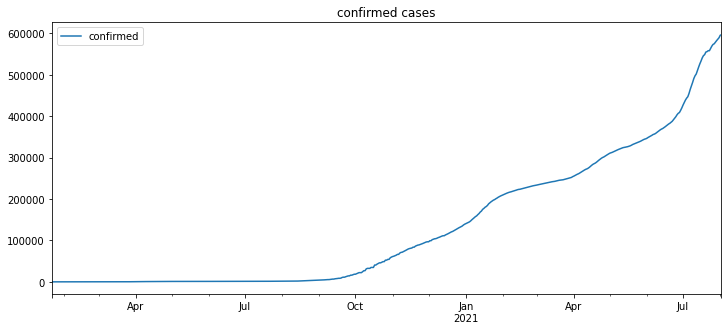

In [ ]:
df_confirmed_country.plot(figsize=(12,5),title='confirmed cases')

In [ ]:
df_confirmed_country.tail(10)

,confirmed
2021-07-24,563930
2021-07-25,569289
2021-07-26,573394
2021-07-27,575002
2021-07-28,578962
2021-07-29,582638
2021-07-30,586146
2021-07-31,589565
2021-08-01,595532
2021-08-02,596775


In [ ]:
print('Total days in the dataSet',len(df_confirmed_country))

Total days in the dataSet 559


In [ ]:
x = len(df_confirmed_country)-14

In [ ]:
train = df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
seq_size = 7 # 7 days
n_features = 1
train_generator = TimeseriesGenerator(train_scaled,train_scaled,length=seq_size,batch_size=1)

In [ ]:
print("Total number of samples in the original training data = ", len(train)) # 545
print("Total number of samples in the generated data = ", len(train_generator)) # 538 with seq_size=7

Total number of samples in the original training data =  545
Total number of samples in the generated data =  538


In [ ]:
x,y = train_generator[10]

In [ ]:
x.shape

(1, 7, 1)

In [ ]:
y.shape

(1, 1)

In [ ]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [ ]:
x,y = test_generator[0]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation

In [ ]:
model =Sequential()
model.add(LSTM(150,activation='relu',return_sequences=True,input_shape=(seq_size,n_features)))
model.add(LSTM(64,activation='relu'))
model.add(Dense(64))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 150)            91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit_generator(train_generator,validation_data=test_generator,epochs=50,steps_per_epoch=10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
10/10 [==============================] - 28s 173ms/step - loss: 0.1078 - val_loss: 0.6458
Epoch 2/50
10/10 [==============================] - 0s 40ms/step - loss: 0.0240 - val_loss: 0.2223
Epoch 3/50
10/10 [==============================] - 0s 47ms/step - loss: 0.0124 - val_loss: 0.0275
Epoch 4/50
10/10 [==============================] - 0s 47ms/step - loss: 8.4244e-04 - val_loss: 0.0019
Epoch 5/50
10/10 [==============================] - 0s 43ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 6/50
10/10 [==============================] - 0s 41ms/step - loss: 8.8702e-04 - val_loss: 2.0226e-05
Epoch 7/50
10/10 [==============================] - 0s 43ms/step - loss: 0.0014 - val_loss: 0.0286
Epoch 8/50
10/10 [==============================] - 0s 46ms/step - loss: 0.0041 - val_loss: 2.7500e-04
Epoch 9/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0015 - val_loss: 0.0177
Epoch 10/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0010 - val_loss

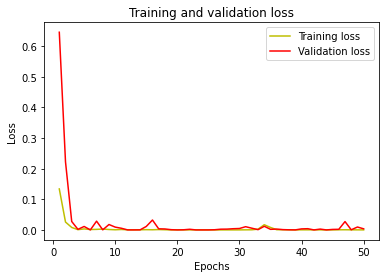

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = []

In [ ]:
current_batch = train_scaled[-seq_size:]
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

In [ ]:
future = 7

In [ ]:
for i in range(len(test)+future):
  current_pred  = model.predict(current_batch)[0]
  predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
rescaled_predictions = scaler.inverse_transform(predictions)

In [ ]:
rescaled_predictions

array([[ 565758.46546233],
       [ 575172.67837298],
       [ 585159.28526723],
       [ 595900.86347175],
       [ 607276.45796072],
       [ 619525.03504527],
       [ 633322.60837412],
       [ 649538.30097198],
       [ 665365.09274328],
       [ 682736.95577157],
       [ 701806.96456218],
       [ 722781.90053022],
       [ 746003.69548738],
       [ 771853.79278433],
       [ 800641.0235064 ],
       [ 832574.98197627],
       [ 868718.48934269],
       [ 909859.42139292],
       [ 957085.45752871],
       [1011863.88884175],
       [1076160.67606223]])

In [ ]:
time_series_array = test.index

In [ ]:
for k in range(0,future):
  time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [ ]:
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

In [ ]:
df_forecast.loc[:,"predicted"] = rescaled_predictions[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

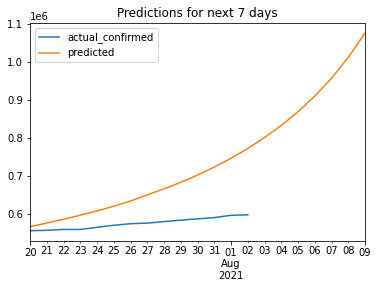

In [ ]:
df_forecast.plot(title="Predictions for next 7 days")